# Table of Contents
* [Load data](#Load-data)
* [dataset validation](#dataset-validation)
* [dataset stats](#dataset-stats)
	* [topic names](#topic-names)
	* [question type dist](#question-type-dist)
	* [looking for missing values](#looking-for-missing-values)
* [html rendering](#html-rendering)
* [building word corpus](#building-word-corpus)
* [End](#End)


In [1]:
%%capture
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict, OrderedDict

import cv2
import pprint
import pickle
import json
import requests
import io
import sys
import os
from binascii import b2a_hex
import base64
from wand.image import Image as WImage
from IPython.display import display
import PIL.Image as Image
from copy import deepcopy
import glob

import json
import enchant
import pickle
import glob

import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder

import language_check

import jsonschema
# from pdfextraction.ck12_new_schema import ck12_schema
from tqa_utils import Evaluator

In [2]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)
# import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

# Load data

In [3]:
dataset_root_dir = '/Users/schwenk/wrk/stb/dataset_releases/data_release_beta6/'
# data_file = 'tqa_dataset_beta6.json'
data_file = 'tqa_dataset_beta7_5.json'

with open(os.path.join(dataset_root_dir, data_file), 'r') as f:
    ck12_combined_dataset_raw = json.load(f)

In [4]:
ck12_combined_dataset = deepcopy(ck12_combined_dataset_raw)

In [5]:
dataset_root_dir = '/Users/schwenk/wrk/stb/dataset_releases/data_release_beta6/'
file_name = 'tqa_dataset_beta7_5.json'
data_file =  dataset_root_dir + file_name

quest_evaluator = Evaluator(data_file)

# basic question types

In [6]:
combined_topics = [lesson['lessonName'] for lesson in ck12_combined_dataset]
topic_series = pd.Series(combined_topics).value_counts()

In [7]:
# topic_series[:20]
len(combined_topics)

1076

In [8]:
q_types = []
for lesson in ck12_combined_dataset:
    for question in lesson['questions']['nonDiagramQuestions'].values():
        q_types.append(question['questionSubType'])
question_counts = pd.Series(q_types).value_counts()
print('total number of questions = ' + str(question_counts.sum()))
question_counts

total number of questions = 18929


Multiple Choice      6582
True or False        5400
Fill in the Blank    3643
Matching             1711
Short Answer         1593
dtype: int64

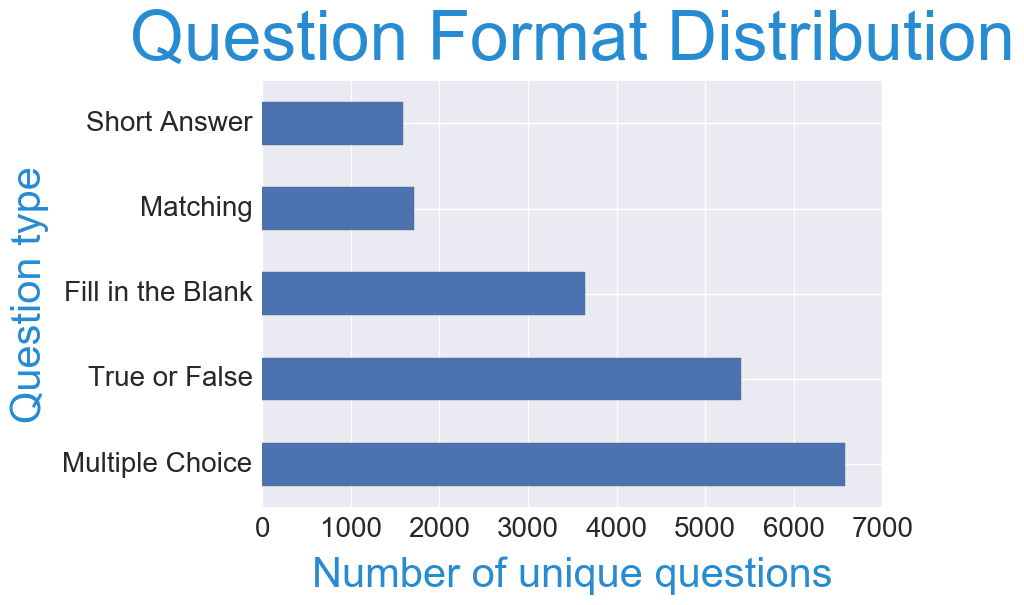

In [9]:
_ = question_counts.plot(kind="barh")
plt.title('Question Format Distribution', fontsize=50, verticalalignment='bottom', color = b16_colors.b)
plt.ylabel("Question type", fontsize=30, labelpad=10, color = b16_colors.b)
plt.xlabel("Number of unique questions", fontsize=30, labelpad=10, color = b16_colors.b)
plt.tick_params(axis='x', which='major', labelsize=20)
plt.tick_params(axis='y', which='major', labelsize=20)

In [10]:
usable_questions = question_counts[:2].append(question_counts[3:4])

In [11]:
sum(usable_questions)

13693

# Non-Diagram Questions

In [6]:
cached_sw = ['?', 'the', 'a', 's', "'", 'this', '.', ',', '_____', '__________', 'an']

In [7]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [8]:
ndq_corpus = ''
for lesson in ck12_combined_dataset:
    for qid, quest in lesson['questions']['nonDiagramQuestions'].items():
        ndq_corpus += ' ' + quest['beingAsked']['processedText'].replace('(', ' ').replace(')', ' ')
        
q_tokens = wordpunct_tokenize(ndq_corpus)
normalized_tokens = [toke.strip().lower().encode('ascii', 'ignore').decode() for toke in q_tokens if toke.strip().lower().encode('ascii', 'ignore').decode() not in cached_sw]
    
qw_freq_d = nltk.FreqDist(normalized_tokens)
most_common_qw = qw_freq_d.most_common(20)

In [9]:
most_common_qw

[('of', 8740),
 ('is', 6556),
 ('in', 4303),
 ('to', 3415),
 ('that', 2788),
 ('are', 2578),
 ('and', 2267),
 ('which', 1691),
 ('what', 1540),
 ('by', 1214),
 ('energy', 1064),
 ('on', 1029),
 ('from', 1011),
 ('water', 987),
 ('can', 972),
 ('for', 948),
 ('when', 944),
 ('called', 892),
 ('with', 868),
 ('it', 856)]

In [10]:
print([word[0] for word in most_common_qw])

['of', 'is', 'in', 'to', 'that', 'are', 'and', 'which', 'what', 'by', 'energy', 'on', 'from', 'water', 'can', 'for', 'when', 'called', 'with', 'it']


In [11]:
phrase_bi_finder = BigramCollocationFinder.from_words(normalized_tokens)
phrase_bi_finder.apply_freq_filter(75) 
# phrase_bi_finder.nbest(bigram_measures.pmi, 10)  

two_word_qtypes = []
for k,v in sorted(phrase_bi_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:15]:
    print(' '.join(k), v)
    two_word_qtypes.append(' '.join(k))

what is 651
which of 491
is called 488
of following 472
type of 387
that is 291
can be 281
example of 271
in which 262
it is 207
which statement 196
amount of 186
used to 174
part of 173
called n 169


In [12]:
# sorted(phrase_bi_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:15]

In [195]:
phrase_tri_finder = TrigramCollocationFinder.from_words(normalized_tokens)
phrase_tri_finder.apply_freq_filter(30) 
# phrase_tri_finder.nbest(trigram_measures.pmi, 20)  

most_common_tri = []
three_word_qtypes = []
for k,v in sorted(phrase_tri_finder.ngram_fd.items(), key=lambda x:x[1], reverse=True)[:9]:
    most_common_tri.append((' '.join(k), v))
    three_word_qtypes.append(' '.join(k))
    print(' '.join(k), v)

which of following 392
of following is 162
is example of 158
is called n 137
which statement about 114
which of these 89
is known as 76
all of following 75
process in which 68


In [229]:
%%capture
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light bright
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)
# import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

In [328]:
def make_and_save_standard_fig(fig_plt, fig_labels=None, outfile='latest_fig.pdf', main_color=b16_colors.b, label_color = '0.25'):
    if fig_labels:
        if 'fig_title' in fig_labels:
            plt.title(fig_labels['fig_title'], fontsize=30, verticalalignment='bottom', color = label_color)
        if 'y_label' in fig_labels:
            plt.ylabel(fig_labels['y_label'], fontsize=25, labelpad=10, color = label_color)
        if 'x_label' in fig_labels:
            plt.xlabel(fig_labels['x_label'], fontsize=25, labelpad=10, color = label_color)
    plt.tick_params(axis='x', which='major', labelsize=15)
    plt.tick_params(axis='y', which='major', labelsize=15)
    plt.savefig(outfile, bbox_inches='tight')

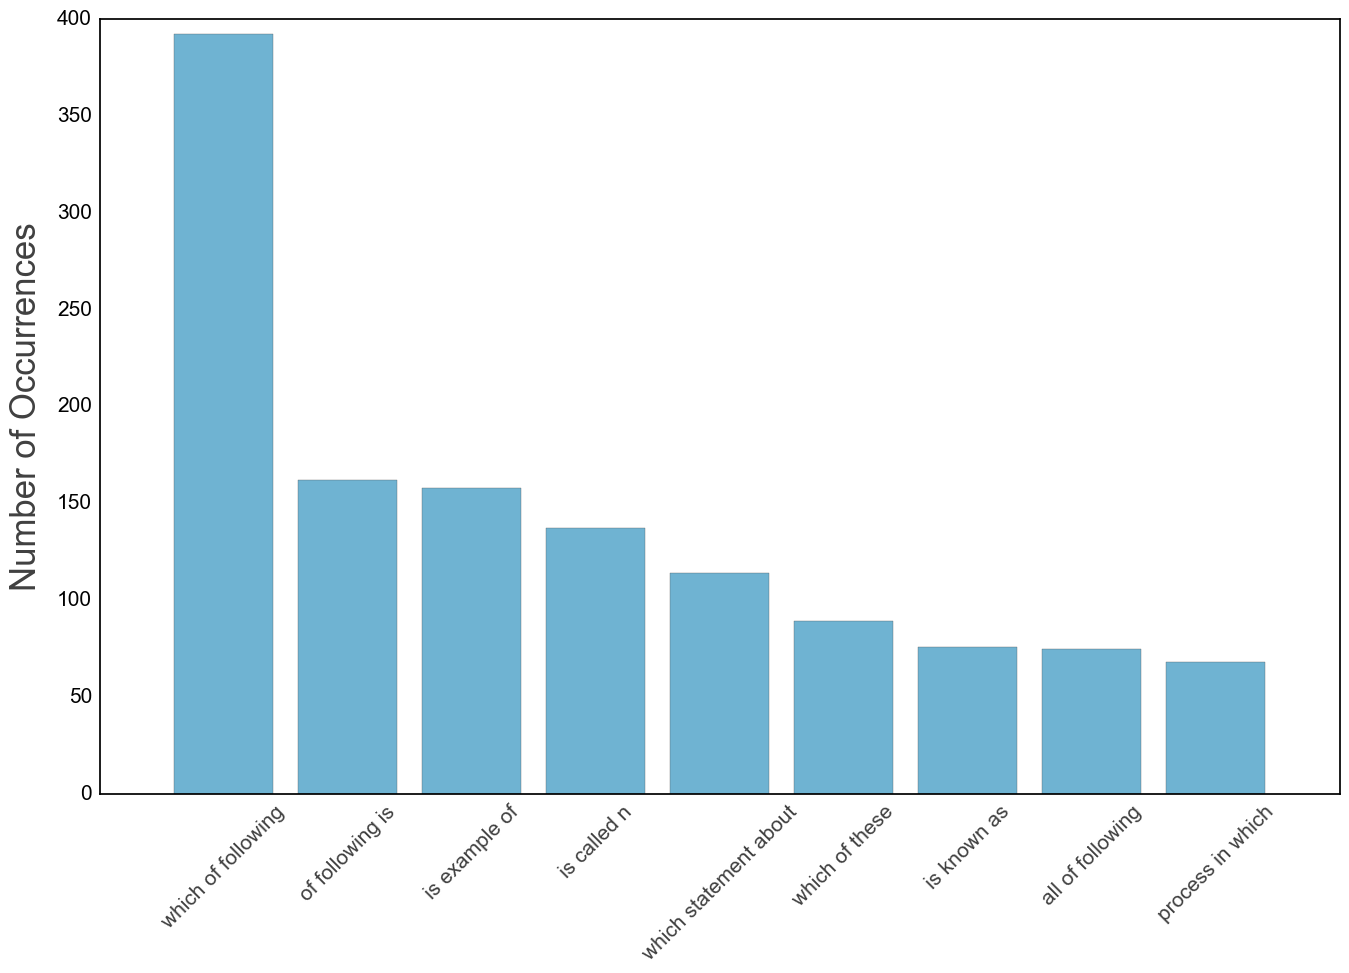

In [315]:
fig_labels = {
#     'fig_title': 'Question Phrase Frequency', 
    'y_label': 'Number of Occurrences', 
#     'x_label': None
}

plt.bar(x_pos, q_num,align='center')
plt.xticks(x_pos, qtype, rotation=45, color=label_color) 

make_and_save_standard_fig(plt, fig_labels, 'q_type_hist.pdf')

In [45]:
high_values_lessons = q_type_df[q_type_df.apply(lambda x: sum(x), axis=1) > 42] ## three word
high_values_lessons = q_type_df[q_type_df.apply(lambda x: sum(x), axis=1) > 375] ## two word

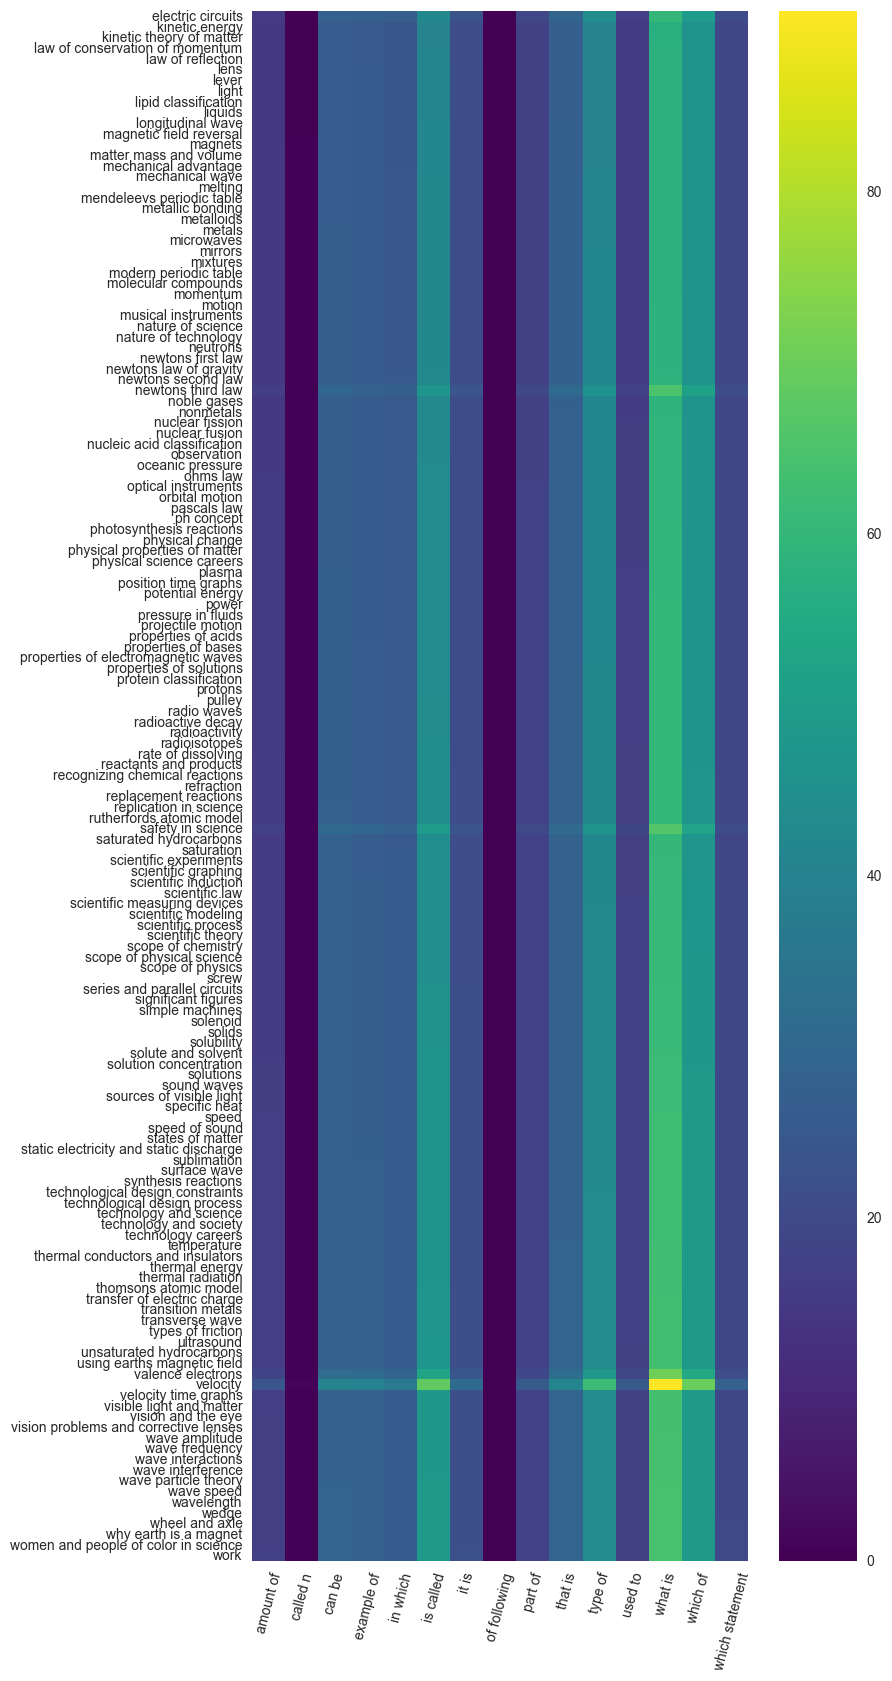

In [47]:
fig, ax = plt.subplots(figsize=(8, 20))
_ = sns.heatmap(high_values_lessons, cmap='viridis', robust=False)
_ = plt.xticks(rotation=75) 

In [241]:
all_ndqs = quest_evaluator.build_question_lookup(by_type=True)['nonDiagramQuestions']
mc_questions = quest_evaluator.build_questions_by_subtype(all_ndqs)['Multiple Choice']

In [244]:
def collect_filtered_question_text(question_dict, filter_phrases=None):
    filtered_questions = {}
    for phrase in filter_phrases:
        for qid, question in question_dict.items():
            question_text = question['beingAsked']['processedText']
            if phrase in question_text:
                filtered_questions[qid] = question_text
    return filtered_questions

In [253]:
reasoning_q_phrases = [' if ', 'what would ', 'what happens']

In [260]:
reasoning_questions = collect_filtered_question_text(all_ndqs, reasoning_q_phrases)

In [261]:
len(reasoning_questions)

142

In [268]:
def make_question_prop_series(questions, property_collector):
    return(pd.Series([property_collector(q) for q in questions.values()]))

In [320]:
question_lengths = make_question_prop_series(all_ndqs, lambda x: len(x['beingAsked']['processedText'].split()))

In [336]:
(question_lengths*100.).shape

(13693,)

In [338]:
np.ones_like(question_lengths*100

(13693,)

0.059999999999999998

In [352]:
vals[3]

0.059999999999999998

In [369]:
'{:2.0f}%'.format(vals[3]*100)

' 6%'

In [382]:
fig_dir = './figs_to_save/'

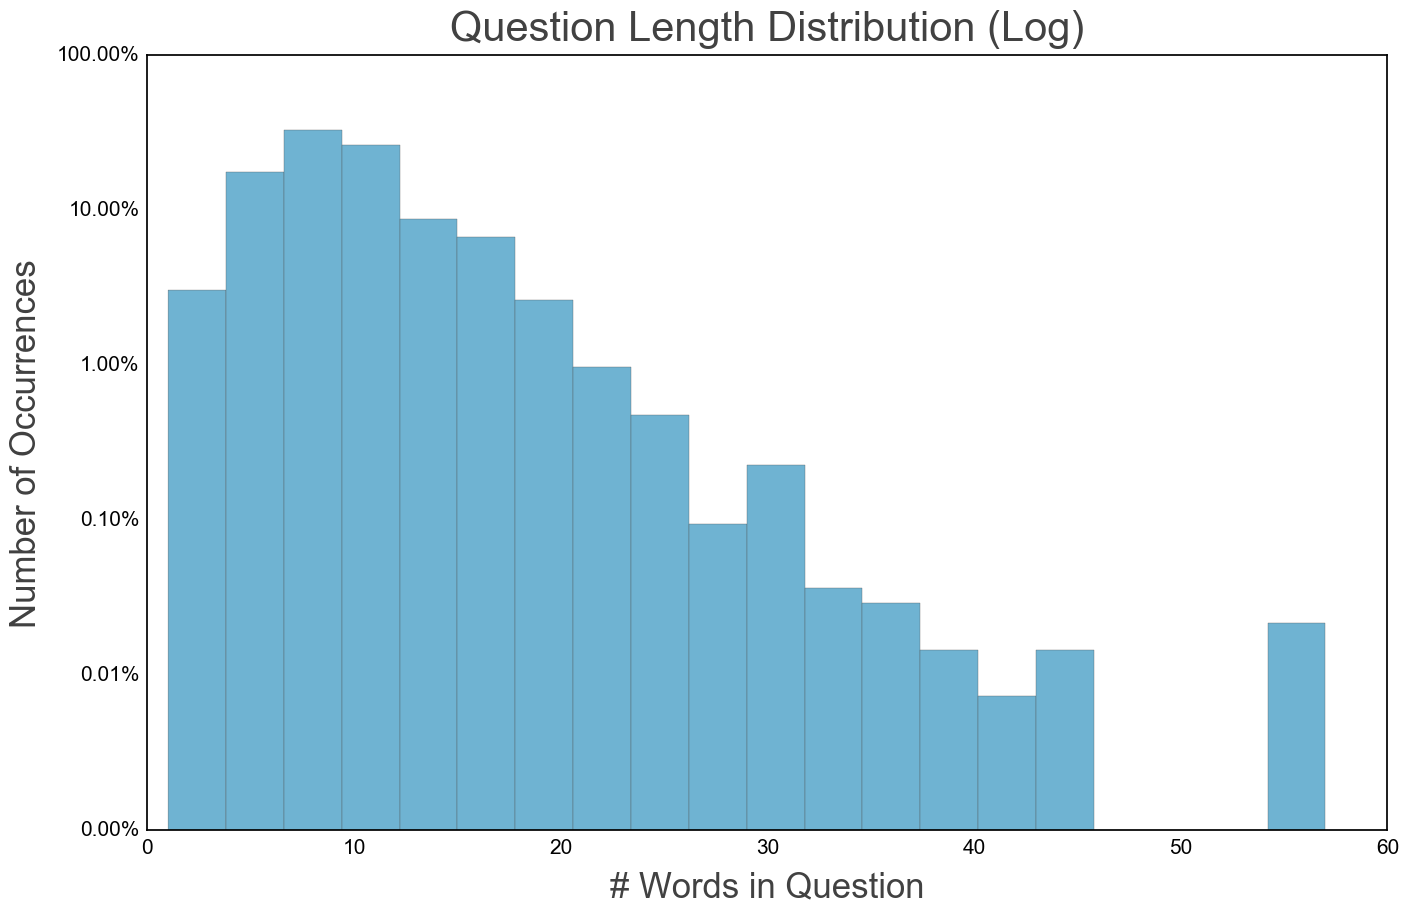

In [389]:
fig_labels = {
    'fig_title': 'Question Length Distribution (Log)', 
    'x_label': '# Words in Question',
    'y_label': 'Number of Occurrences'
}
weights = np.ones_like(question_lengths)/len(question_lengths)
plot_to_save = question_lengths.hist(bins= 20, log=True, weights=weights)
tick_labels = plot_to_save.get_yticks()
plot_to_save.set_yticklabels(['{:2.2f}%'.format(i*100) for i in tick_labels])

image_filename = fig_dir +  fig_labels['fig_title'].lower().replace(' ', '_') + '.pdf'
make_and_save_standard_fig(plot_to_save, fig_labels,  image_filename)

## looking at all/some/none of the above questions

In [125]:
question_asks = {}
answer_choices_with_above = []
correct_answer_choices_with_above = []
for qid, question in mc_questions.items(): 
    question_text = question['beingAsked']['processedText']
    ans_choices = {acid: ac['processedText'] for acid, ac in question['answerChoices'].items() if 'the above' in ac['processedText'].lower()}
    if ans_choices:
        above_choice_correct = 'd' == question['correctAnswer']['processedText']
        correct_answer_choices_with_above.append(above_choice_correct)
    answer_choices_with_above += list(ans_choices.values())
    question_asks[qid] = question_text

sum(correct_answer_choices_with_above) / len(answer_choices_with_above)

len(answer_choices_with_above)

## hide

In [232]:
# for qid, q in sorted(question_asks.items(), key=lambda x: len(x[1]), reverse=True)[:20]:
#     print(q)
# #     print(mc_questions[qid]['answerChoices'])
#     print()

In [161]:
# plt.scatter(xns, yb, color=b16_colors.g, marker = 'o', s=45)
# plt.plot(xns, lin_mod.predict(np.array(xns).reshape(-1,1)), color=b16_colors.b ,alpha=0.8, linewidth=5.0)
# plt.xlim((0,100))
# plt.ylim((0, 1))
# label_color =  b16_colors.b
# plt.title('Ingredient Cooccurrences', fontsize=50, verticalalignment='bottom', color = label_color)
# plt.ylabel("Fraction of pairs extant", fontsize=30, labelpad=15, color = label_color)
# plt.xlabel("Number of shared flavor compounds", fontsize=30, labelpad=10, color = label_color)
# plt.tick_params(axis='x', which='major', labelsize=20)
# plt.tick_params(axis='y', which='major', labelsize=20)